In [5]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.linear_model import LogisticRegression
import seaborn as sns

### Titanic Problem

Make yourself familiar with the [data dictionary](https://www.kaggle.com/c/titanic/data).

** Goals **

1. Spend a few minutes determining which data would be most important to use in the prediction problem. You may need to create new features based on the data available. Consider using a feature selection aide in sklearn. But a worst case scenario; identify one or two strong features that would be useful to include in the model.
2. Spend 1-2 minutes considering which _metric_ makes the most sense to optimize. Accuracy? FPR or TPR? AUC? Given the business problem (understanding survival rate aboard the Titanic), why should you use this metric?
3. Build a tuned Logistic model. Be prepared to explain your design (including regularization), metric, and feature set in predicting survival using the tools necessary (such as a fit chart).

In [6]:
train = pd.read_csv('../data/titanic.csv')
train.info()

IOError: File ../data/titanic.csv does not exist

##### Which variables have missing data?

##### Answer:

##### Take a look at the variable types

In [67]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [68]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


##### What's the bias or prevalence for the titanic data?

In [2]:
train.Survived.value_counts()
#value_counts can only take a series, so one variable at a time

NameError: name 'train' is not defined

##### Set `PassengerId` as `index`

In [70]:
train.set_index('PassengerId', inplace=True)

##### How does survival probability compare for males and females?

Hint: Use [pd.crosstab](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.crosstab.html)!

In [71]:
pd.crosstab(train.Survived, train.Sex, normalize='columns', margins=True)

Sex,female,male,All
Survived,,,
0,0.257962,0.811092,0.616162
1,0.742038,0.188908,0.383838


##### Convert the `Sex` variable to a dummy (use `.map()`)

In [72]:
# female = 0, Male = 1
train['Sex'] = train.Sex.map({'female': 0, 'male': 1}).astype(int)

##### How does Pclass affect survival probability?

In [73]:
pd.crosstab(train.Survived, train.Pclass, normalize='columns', margins=True)

Pclass,1,2,3,All
Survived,,,,
0,0.37037,0.527174,0.757637,0.616162
1,0.62963,0.472826,0.242363,0.383838


In [74]:
train = train.join(pd.get_dummies(train.Pclass, prefix='class'))

##### How does Age affect survival?

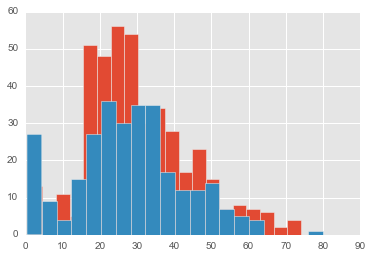

In [75]:
train.groupby('Survived').Age.hist(bins=20);

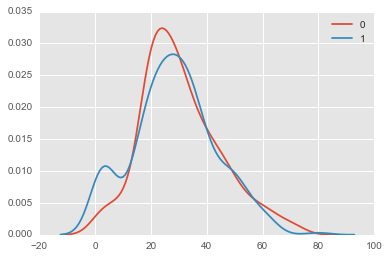

In [76]:
fig, ax = plt.subplots()
for g, df in train.groupby('Survived'):
    sns.kdeplot(df.Age, ax=ax, label=g);

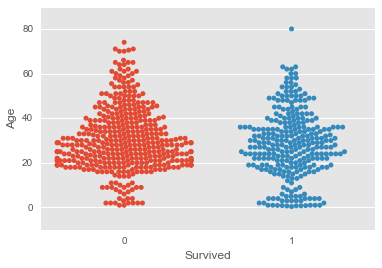

In [77]:
sns.swarmplot(x='Survived', y='Age', data=train);

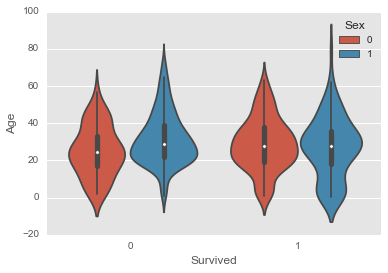

In [78]:
sns.violinplot(x='Survived', y='Age', hue='Sex', data=train);

##### Replace `Embarked` missing values of with  most frequent port

In [79]:
train.Embarked.isnull().sum()

2

In [80]:
train.Embarked.fillna(train.Embarked.dropna().mode().iloc[0], inplace=True) #.mode() spits out mode and frequency; we only want frequency, hence the iloc[0]

In [81]:
pd.crosstab(train.Survived, train.Embarked, normalize='columns', margins=True)

Embarked,C,Q,S,All
Survived,,,,
0,0.446429,0.61039,0.660991,0.616162
1,0.553571,0.38961,0.339009,0.383838


##### Add `Embarked` dummy variables

In [82]:
# check out factorize
# train.Embarked = pd.factorize(train.Embarked)[0]
train = train.join(pd.get_dummies(train.Embarked, prefix='port')).drop('Embarked', axis=1)

##### Create `family_size` variable using `SibSp` and `Parch`

In [83]:
train['fam_size'] = train.SibSp + train.Parch + 1

In [84]:
train.SibSp.value_counts().sort_index()

0    608
1    209
2     28
3     16
4     18
5      5
8      7
Name: SibSp, dtype: int64

In [85]:
pd.crosstab(train.Survived, train.SibSp, normalize='columns', margins=True)

SibSp,0,1,2,3,4,5,8,All
Survived,,,,,,,,
0,0.654605,0.464115,0.535714,0.75,0.833333,1.0,1.0,0.616162
1,0.345395,0.535885,0.464286,0.25,0.166667,0.0,0.0,0.383838


In [86]:
train.Parch.value_counts().sort_index()

0    678
1    118
2     80
3      5
4      4
5      5
6      1
Name: Parch, dtype: int64

In [87]:
pd.crosstab(train.Survived, train.Parch, normalize='columns', margins=True)

Parch,0,1,2,3,4,5,6,All
Survived,,,,,,,,
0,0.656342,0.449153,0.5,0.4,1.0,0.8,1.0,0.616162
1,0.343658,0.550847,0.5,0.6,0.0,0.2,0.0,0.383838


In [88]:
# probably not quite correct
train.fam_size.value_counts().sort_index()

1     537
2     161
3     102
4      29
5      15
6      22
7      12
8       6
11      7
Name: fam_size, dtype: int64

In [89]:
pd.crosstab(train.Survived, train.fam_size, normalize='columns', margins=True)

fam_size,1,2,3,4,5,6,7,8,11,All
Survived,,,,,,,,,,
0,0.696462,0.447205,0.421569,0.275862,0.8,0.863636,0.666667,1.0,1.0,0.616162
1,0.303538,0.552795,0.578431,0.724138,0.2,0.136364,0.333333,0.0,0.0,0.383838


In [90]:
train.fam_size = train.fam_size.apply(lambda x: 5 if x in [5, 6] else x).clip_upper(8)

In [91]:
pd.crosstab(train.Survived, train.fam_size, normalize='columns', margins=True)

fam_size,1,2,3,4,5,7,8,All
Survived,,,,,,,,
0,0.696462,0.447205,0.421569,0.275862,0.837838,0.666667,1.0,0.616162
1,0.303538,0.552795,0.578431,0.724138,0.162162,0.333333,0.0,0.383838


In [92]:
train = train.join(pd.get_dummies(train.fam_size, prefix='fam_size')).drop('fam_size', axis=1)

##### Optional: Extract `deck` information from `Cabin` variable

In [93]:
#
train['deck'] = train.Cabin.str.findall(r'[\A-Z]').str.join('').str.get(-1)
train.deck.value_counts().sort_index()

A    15
B    47
C    59
D    33
E    33
F     9
G     7
T     1
Name: deck, dtype: int64

In [94]:
pd.crosstab(train.Survived, train.deck, normalize='columns', margins=True)

deck,A,B,C,D,E,F,G,T,All
Survived,,,,,,,,,
0,0.533333,0.255319,0.40678,0.242424,0.242424,0.222222,0.714286,1.0,0.333333
1,0.466667,0.744681,0.59322,0.757576,0.757576,0.777778,0.285714,0.0,0.666667


In [95]:
train.deck = train.deck.apply(lambda x: 'B' if x in ['B', 'D', 'E', 'F'] else x)
train.deck = train.deck.apply(lambda x: 'G' if x in ['G', 'T'] else x)

In [96]:
train = train.join(pd.get_dummies(train.deck, prefix='deck')).drop('deck', axis=1)

##### Optional: Extract family names

In [7]:
train['last_name'] = train.Name.str.split(',').str.get(0).str.strip() #getting the last name, then stripping everything after the comma and the comma
train['last_name'] = pd.factorize(train.last_name)[0]

NameError: name 'train' is not defined

##### Optional: Create `title` variable using `last_name` information

In [98]:
train['title'] = train.Name.str.split(',').str.get(1).str.split('.').str.get(0).str.strip()
title_dict = {'Mlle': 'Miss', 'Mme': 'Mrs', 'Ms': 'Miss'}
rare = ['Dr', 'Rev', 'Col', 'Major', 'Capt', 'Jonkheer', 'Don', 'Sir', 'the Countess', 'Lady']
title_dict.update({r: 'Rare' for r in rare})
train = train.replace(to_replace={'title': title_dict})
train.title.value_counts()

Mr        517
Miss      185
Mrs       126
Master     40
Rare       23
Name: title, dtype: int64

In [99]:
train = train.join(pd.get_dummies(train.title, prefix='title')).drop('title', axis=1)

In [100]:
train['had_parents'] = train.Parch.apply(lambda x: 1 if x > 0 else 0)
train['had_siblings'] = train.SibSp.apply(lambda x: 1 if x > 0 else 0)

##### Imputing Age: Prediction via Linear Regression

In [101]:
train.drop(['Ticket', 'Name', 'Cabin', 'SibSp', 'Parch', 'last_name'], axis=1, inplace=True)
print(train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 29 columns):
Survived        891 non-null int64
Pclass          891 non-null int64
Sex             891 non-null int64
Age             714 non-null float64
Fare            891 non-null float64
class_1         891 non-null float64
class_2         891 non-null float64
class_3         891 non-null float64
port_C          891 non-null float64
port_Q          891 non-null float64
port_S          891 non-null float64
fam_size_1      891 non-null float64
fam_size_2      891 non-null float64
fam_size_3      891 non-null float64
fam_size_4      891 non-null float64
fam_size_5      891 non-null float64
fam_size_7      891 non-null float64
fam_size_8      891 non-null float64
deck_A          891 non-null float64
deck_B          891 non-null float64
deck_C          891 non-null float64
deck_G          891 non-null float64
title_Master    891 non-null float64
title_Miss      891 non-null float64
title_Mr     

0.4641588833612782

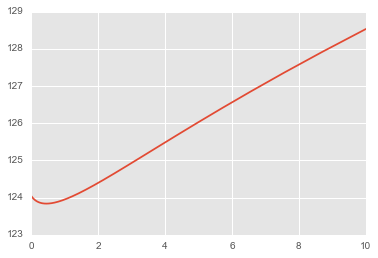

In [102]:
#use linear regression to try to predict age
#because 25% of observations were missing age, we're trying to back into values for it and then imputing
from sklearn.linear_model import Ridge
from sklearn.cross_validation import cross_val_score

alphas = np.logspace(-5, 1, 100)
model = Ridge()
excludes = ['Age', 'Pclass', 'class_1', 'port_C', 'title_Rare', 'fam_size_1']
X = train.dropna(subset=['Age']).drop(excludes, axis=1)
y = train.Age.dropna()

score, coefs = {}, {}
for a in alphas:
    model.set_params(alpha=a)
    mse = -cross_val_score(estimator=model, 
                         X=X, y=y, cv=5, scoring='mean_squared_error')
    score[a] = np.mean(mse)
mse = pd.Series(score)
mse.plot();
mse.idxmin()

In [50]:
model.set_params(alpha=mse.idxmin())
model.fit(X, y`)

Ridge(alpha=0.4641588833612782, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

115.68791295524414

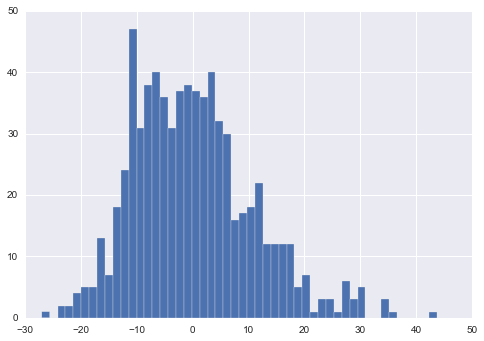

In [51]:
train_error_1 = train.Age.dropna() - model.predict(X)
train_error_1.hist(bins=50);
train_error_1.pow(2).mean()

175.98883902932045

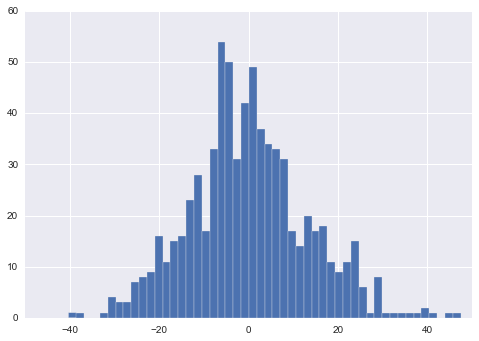

In [52]:
df = train.dropna(subset=['Age'])
train_error_2 = df.Age - df.groupby(["Sex", 'Pclass']).Age.transform('mean')
train_error_2.hist(bins=50);
train_error_2.pow(2).mean()

In [53]:
train.loc[pd.isnull(train.Age), 'Age'] = model.predict(train[pd.isnull(train.Age)].drop(excludes, axis=1))
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 29 columns):
Survived        891 non-null int64
Pclass          891 non-null int64
Sex             891 non-null int64
Age             891 non-null float64
Fare            891 non-null float64
class_1         891 non-null float64
class_2         891 non-null float64
class_3         891 non-null float64
port_C          891 non-null float64
port_Q          891 non-null float64
port_S          891 non-null float64
fam_size_1      891 non-null float64
fam_size_2      891 non-null float64
fam_size_3      891 non-null float64
fam_size_4      891 non-null float64
fam_size_5      891 non-null float64
fam_size_7      891 non-null float64
fam_size_8      891 non-null float64
deck_A          891 non-null float64
deck_B          891 non-null float64
deck_C          891 non-null float64
deck_G          891 non-null float64
title_Master    891 non-null float64
title_Miss      891 non-null float64
title_Mr     

In [54]:
train.drop('Pclass', axis=1, inplace=True)

##### Predict survival using KNN

27 50 3


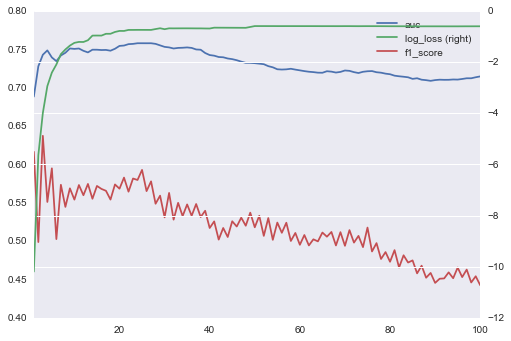

In [55]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV

neighbors = np.arange(100) + 1
X = train.drop('Survived', axis=1)
y = train.Survived
knn = KNeighborsClassifier()

auc, log_loss, f1_score = {}, {}, {}
for k in neighbors:
    knn.set_params(n_neighbors=k)
    auc[k] = np.mean(cross_val_score(knn, X=X, y=y, cv=5, scoring='roc_auc')) #want auc as high as possible
    log_loss[k] = np.mean(cross_val_score(knn, X=X, y=y, cv=5, scoring='log_loss'))    #logloss measures how sure you thought you were
    f1_score[k] = np.mean(cross_val_score(knn, X=X, y=y, cv=5, scoring='f1'))   #f1_score as hi as poss     
scores = pd.concat([pd.Series(auc, name='auc'), pd.Series(log_loss, name='log_loss'), pd.Series(f1_score, name='f1_score')], axis=1)
scores.plot(secondary_y='log_loss');
print scores.auc.idxmax(), scores.log_loss.idxmax(), scores.f1_score.idxmax()

5 0.737891328199
10 0.749608538651
20 0.753467229093
30 0.7510092779
50 0.725929121529


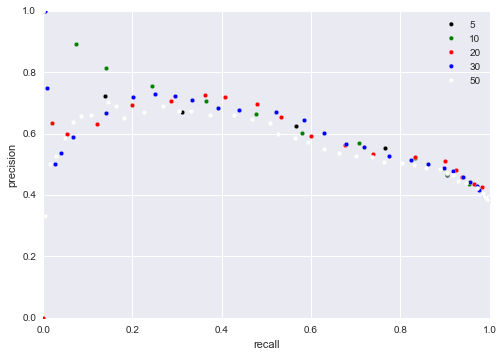

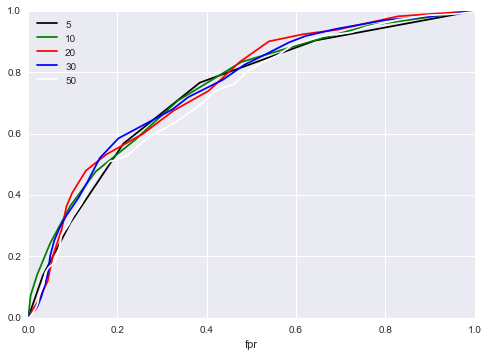

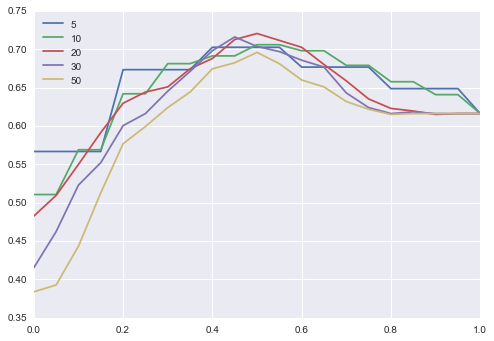

In [62]:
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import precision_recall_curve, roc_curve, accuracy_score, roc_auc_score
from sklearn.preprocessing import Binarizer

neighbors = [5, 10, 20, 30, 50]
knn = KNeighborsClassifier()
skf = StratifiedKFold(y, 5)
binarizer = Binarizer()
y_true = pd.concat([y.iloc[test] for _, test in skf])

fig, ax = plt.subplots()
fig1, ax1 = plt.subplots()
colors = ['black', 'green', 'red', 'blue', 'white']
acc_score = pd.DataFrame()
for i, k in enumerate(neighbors): #iterating through # neighbors
    knn.set_params(n_neighbors=k)
    y_preds = pd.Series(name=k)
    for fold, (train, test) in enumerate(skf):
        knn.fit(X.iloc[train], y.iloc[train])
        y_preds = pd.concat([y_preds, pd.Series(knn.predict_proba(X.iloc[test])[:, 1])])
    
    precision, recall, _ = precision_recall_curve(y_true, y_preds)
    fpr, tpr, _ = roc_curve(y_true, y_preds)

    pd.DataFrame({'precision': precision, 'recall': recall}).plot.scatter(
        x='recall', y='precision', ax=ax, label=k, c=colors[i], xlim=[0,1], ylim=[0,1])
    pd.DataFrame({'tpr': tpr, 'fpr': fpr}).plot(
        x='fpr', y='tpr', ax=ax1, label=k, c=colors[i], xlim=[0,1], ylim=[0,1])

    accuracy = {}
    for threshold in np.arange(0, 1.01, 0.05):
        binarizer.set_params(threshold=threshold)
        accuracy[threshold] = accuracy_score(y_true, binarizer.transform(y_preds.reshape(-1, 1)).ravel())
    acc_score = pd.concat([acc_score, pd.Series(accuracy).to_frame(k)], axis=1)
    print k, roc_auc_score(y_true=y_true, y_score=y_preds)
acc_score.plot();

##### Predict survival using Logistic Regression

In [63]:
from sklearn import grid_search, cross_validation

gs = grid_search.GridSearchCV(
    estimator=LogisticRegression(),#first thing takes model form
    param_grid={'C': [10**-i for i in range(-5, 5)], 'class_weight': [None, 'balanced']}, #tell it params
    cv=cross_validation.KFold(n=len(train), n_folds=5), #tell it #folds
    scoring='roc_auc'#tell it what you want to score it by
)


gs.fit(X, y)
gs.grid_scores_

[mean: 0.85535, std: 0.01369, params: {'C': 100000, 'class_weight': None},
 mean: 0.85368, std: 0.01472, params: {'C': 100000, 'class_weight': 'balanced'},
 mean: 0.85531, std: 0.01366, params: {'C': 10000, 'class_weight': None},
 mean: 0.85368, std: 0.01472, params: {'C': 10000, 'class_weight': 'balanced'},
 mean: 0.85532, std: 0.01362, params: {'C': 1000, 'class_weight': None},
 mean: 0.85368, std: 0.01475, params: {'C': 1000, 'class_weight': 'balanced'},
 mean: 0.85660, std: 0.01344, params: {'C': 100, 'class_weight': None},
 mean: 0.85425, std: 0.01483, params: {'C': 100, 'class_weight': 'balanced'},
 mean: 0.85999, std: 0.01402, params: {'C': 10, 'class_weight': None},
 mean: 0.85859, std: 0.01432, params: {'C': 10, 'class_weight': 'balanced'},
 mean: 0.86059, std: 0.01525, params: {'C': 1, 'class_weight': None},
 mean: 0.86029, std: 0.01481, params: {'C': 1, 'class_weight': 'balanced'},
 mean: 0.85819, std: 0.01882, params: {'C': 0.1, 'class_weight': None},
 mean: 0.85754, std: 0

In [157]:
gs.best_estimator_

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [159]:
gs.best_score_

0.86059038296505075

In [50]:
model = gs.best_estimator_

In [56]:
model.fit(X, y) #create model based on best estimator

[LibLinear]

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=1, warm_start=False)

In [59]:
model.coef_

array([[ -1.21311436e+00,  -3.50819229e-02,   3.83117881e-03,
          9.81125858e-01,   3.36306784e-01,  -6.20184101e-01,
          3.50953873e-01,   3.47328828e-01,  -1.03415937e-03,
          9.27642288e-01,   6.34868245e-01,   1.01394623e+00,
          8.86704634e-01,  -1.36813318e+00,  -8.11597336e-02,
         -1.31661994e+00,   6.25293010e-01,   1.14369002e+00,
          2.73085576e-01,  -4.96992055e-01,   1.41734878e+00,
          2.13862653e-01,  -1.25796790e+00,   1.10160581e+00,
         -7.77600799e-01,  -4.23363068e-01,  -1.37592729e-01]])

In [61]:
model.set_params(penalty='l1')
for i, C in enumerate((100, 10, 1, 0.1, 0.01)):
    model.set_params(C=C)
    model.fit(X, y)
    print model.coef_.ravel()

[LibLinear][ -3.53062699e+00  -3.69648412e-02   4.58424726e-03   1.36185289e+00
   7.21663819e-01  -2.31929146e-01   8.33325203e-01   8.93666903e-01
   5.28219366e-01   1.22594183e+00   6.67463550e-01   9.97837000e-01
   9.76434871e-01  -2.13587548e+00  -4.37966436e-01  -6.86128641e+00
   8.92498130e-01   1.27229090e+00   4.05788693e-01  -9.62522819e-01
   3.86959695e+00  -2.64784900e-01   4.60424364e-01   7.52508373e-01
   6.04751920e-01  -2.91110890e-01   3.12320682e-02]
[LibLinear][-2.7039598  -0.03634882  0.00452185  1.60754616  0.95191633  0.          0.3069495
  0.35567188  0.          1.18678146  0.66827828  1.00674044  0.97829085
 -2.054118   -0.35640395 -4.48354097  0.85493115  1.24855048  0.36846333
 -0.8768627   3.2211047  -0.03359269 -0.13322683  0.9598563   0.00976566
 -0.31455204  0.        ]
[LibLinear][-2.31161009 -0.03267233  0.00434163  1.34093243  0.5899223  -0.32828769
  0.31611714  0.29633675  0.          1.01347873  0.55083671  0.8350312
  0.6661092  -1.70970735  